This notebook compares different weighting approaches for the SP500 - we're testing max sharpe, min vol and max quadratic utility weights (using the efficient frontier methods from pyportfolioopt), hierarchical risk parity, and equal weighted. 

We then take test these in a walk-forward setting, i.e. defining the weights on in-sample, measure performance on out-of-sample.

Note - our approach DOES NOT consider a historical list of constituents of the S&P 500, thus lookahead bias is certainly affecting our result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import vectorbt as vbt
import empyrical as ep

In [4]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.hierarchical_portfolio import HRPOpt

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Load S&P 500 Constituents

In [6]:
def get_sp500_tickers():
    # Wikipedia URL for the S&P 500 list
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    # Send an HTTP request to the URL
    response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the table containing the S&P 500 tickers
        table = soup.find('table', {'class': 'wikitable'})
        
        # Extract tickers from the table
        tickers = []
        for row in table.find_all('tr')[1:]:  # Skip the header row
            ticker = row.find_all('td')[0].text.strip()
            tickers.append(ticker)
        
        return tickers
    else:
        # If the request was unsuccessful, print an error message
        print(f"Error: Unable to retrieve data from {url}")
        return None

# Get the list of S&P 500 tickers
sp500_tickers = get_sp500_tickers()

In [7]:
df = yf.download(' '.join(sp500_tickers), period='10y')['Adj Close']
df.dropna(axis=1, inplace=True)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [15]:
spy = yf.download('spy', period='10y')['Adj Close']

[*********************100%%**********************]  1 of 1 completed


Date
2014-05-08    156.845978
2014-05-09    157.079987
2014-05-12    158.609344
2014-05-13    158.751404
2014-05-14    157.999298
                 ...    
2024-05-01    500.350006
2024-05-02    505.029999
2024-05-03    511.290009
2024-05-06    516.570007
2024-05-07    517.140015
Name: Adj Close, Length: 2517, dtype: float64

### Compute weighted portfolios

In [128]:
# Max Sharpe
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
weights_max_sharpe = ef.max_sharpe()
# ef.portfolio_performance(verbose=True)

In [129]:
# Min Volatility
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
weights_min_vol = ef.min_volatility()
# ef.portfolio_performance(verbose=True)

In [130]:
# Max Quadratic Utility
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
weights_max_quad_util = ef.max_quadratic_utility(0.7)
# ef.portfolio_performance(verbose=True)

In [131]:
# Hiearchical Risk Parity
weights_hrp = HRPOpt(df.pct_change().replace(np.nan, 0)).optimize()

In [120]:
# Formulating weighted portfolios

pf_sharpe, pf_vol, pf_quad, pf_hrp = {}, {}, {}, {}
for asset in df.columns:
    pf_sharpe[asset] = df[asset].pct_change() * weights_max_sharpe[asset]
    pf_vol[asset] = df[asset].pct_change() * weights_min_vol[asset]
    pf_quad[asset] = df[asset].pct_change() * weights_max_quad_util[asset]
    pf_hrp[asset] = df[asset].pct_change() * weights_hrp[asset]

pf_sharpe = pd.DataFrame(pf_sharpe)
pf_vol = pd.DataFrame(pf_vol)
pf_quad = pd.DataFrame(pf_quad)
pf_hrp = pd.DataFrame(pf_hrp)

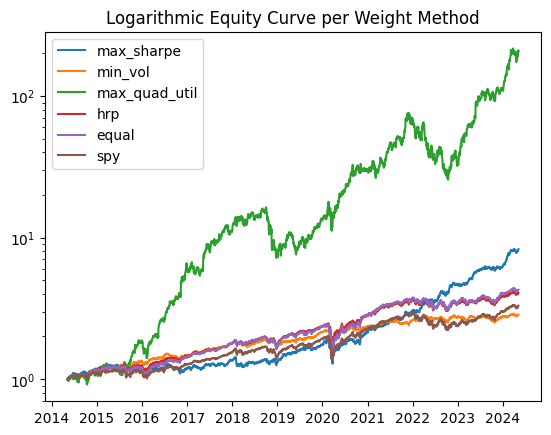

In [123]:
equities = pd.DataFrame({
    'max_sharpe':(1+pf_sharpe.sum(axis=1)).cumprod(),
    'min_vol':(1+pf_vol.sum(axis=1)).cumprod(),
    'max_quad_util':(1+pf_quad.sum(axis=1)).cumprod(),
    'hrp':(1+pf_hrp.sum(axis=1)).cumprod(),
    'equal':(1+df.pct_change().mean(axis=1)).cumprod(),
    'spy':(1+spy.pct_change()).cumprod()
})

plt.title('Logarithmic Equity Curve per Weight Method')
plt.semilogy(equities)
plt.legend(equities.columns)
plt.show()

In [124]:
stats = pd.concat([
    equities.pct_change().fillna(0).apply(ep.sharpe_ratio),
    equities.pct_change().fillna(0).apply(ep.max_drawdown),
    equities.pct_change().fillna(0).apply(ep.cagr)], axis=1)

stats.columns = ['sharpe', 'maxdd', 'cagr']
stats

sharpe     maxdd      cagr
max_sharpe     1.251727 -0.330082  0.235639
min_vol        0.865243 -0.238068  0.110697
max_quad_util  1.365512 -0.663351  0.705260
hrp            0.944552 -0.335042  0.150544
equal          0.882616 -0.384684  0.156349
spy            0.768965 -0.337173  0.126705

### Walk-forward Weighting

It's easy to tell which weighting method is favorable when computing the weights on hindsight. In order to have a more realistic view, we can compute the weights on an in-sample period, then test how they perform on new, out-of-sample data.

We will do this using walk-forward analysis. Essentially, we will be splitting out data into in/out of sample batches, selecting the weights on the in-sample period and then measuring the performance on the out-of-sample.

Let's get to it.

In [143]:
# Split into 5 batches

split_kwargs = dict(
    n=5, 
    window_len=365 * 3, 
    set_lens=(357,), 
    left_to_right=False, 
)  

def roll_in_and_out_samples(price, **kwargs):
    return price.vbt.rolling_split(**kwargs)

(in_price, in_indexes), (out_price, out_indexes) = roll_in_and_out_samples(df, **split_kwargs)

print(in_price.shape, len(in_indexes))  # in-sample
print(out_price.shape, len(out_indexes))  # out-sample

(738, 2330) 5
(357, 2330) 5


In [72]:
# Compute weights in in-sample, then measure performance on out-of-sample

pf_sharpe, pf_vol, pf_quad, pf_hrp = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for i in tqdm(range(5)):

    # Load batch data
    in_batch = in_price[i]
    in_batch.index = in_indexes[i]
    out_batch = out_price[i]
    out_batch.index = out_indexes[i]

    # Compute in-sample weights
    
    # - Max Sharpe
    mu = expected_returns.mean_historical_return(in_batch)
    S = risk_models.sample_cov(in_batch)
    ef = EfficientFrontier(mu, S)
    w_sr = ef.max_sharpe()
    
    # - Min Volatility
    mu = expected_returns.mean_historical_return(in_batch)
    S = risk_models.sample_cov(in_batch)
    ef = EfficientFrontier(mu, S)
    w_vol = ef.min_volatility()

    # - Max Quadratic Utility
    mu = expected_returns.mean_historical_return(in_batch)
    S = risk_models.sample_cov(in_batch)
    ef = EfficientFrontier(mu, S)
    w_quad = ef.max_quadratic_utility(0.7)

    # - HRP
    w_hrp = HRPOpt(in_batch.pct_change().replace(np.nan, 0)).optimize()

    # Compute out-of-sample portfolio performance
    
    _pf_sharpe, _pf_vol, _pf_quad, _pf_hrp = {}, {}, {}, {}
    for asset in df.columns:
        _pf_sharpe[asset] = out_batch[asset].pct_change() * w_sr[asset]
        _pf_vol[asset] = out_batch[asset].pct_change() * w_vol[asset]
        _pf_quad[asset] = out_batch[asset].pct_change() * w_quad[asset]
        _pf_hrp[asset] = out_batch[asset].pct_change() * w_hrp[asset]
    pf_sharpe = pd.concat([pf_sharpe, pd.DataFrame(_pf_sharpe)])
    pf_vol = pd.concat([pf_vol, pd.DataFrame(_pf_vol)])
    pf_quad = pd.concat([pf_quad, pd.DataFrame(_pf_quad)])
    pf_hrp = pd.concat([pf_hrp, pd.DataFrame(_pf_hrp)])

100%|██████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.65s/it]


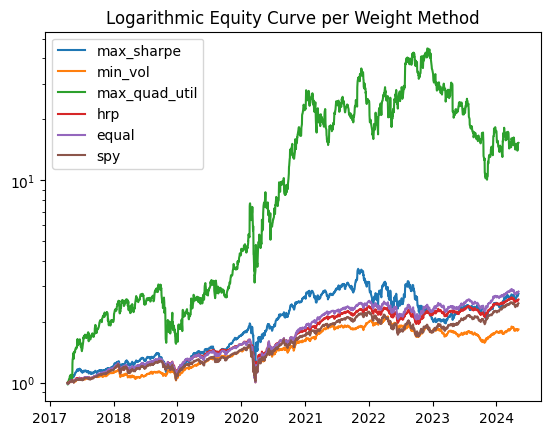

In [112]:
equities = pd.DataFrame({
    'max_sharpe':(1+pf_sharpe.sum(axis=1)).cumprod(),
    'min_vol':(1+pf_vol.sum(axis=1)).cumprod(),
    'max_quad_util':(1+pf_quad.sum(axis=1)).cumprod(),
    'hrp':(1+pf_hrp.sum(axis=1)).cumprod(),
    'equal':(1+df.pct_change().mean(axis=1).loc[pf_sharpe.index]).cumprod(),
    'spy':(1+spy.pct_change().loc[pf_sharpe.index]).cumprod()
})

plt.title('Logarithmic Equity Curve per Weight Method')
plt.semilogy(equities)
plt.legend(equities.columns)
plt.show()

In [134]:
stats = pd.concat([
    equities.pct_change().fillna(0).apply(ep.sharpe_ratio).round(2),
    equities.pct_change().fillna(0).apply(ep.max_drawdown).mul(100).round(2),
    equities.pct_change().fillna(0).apply(ep.cagr).mul(100).round(2)], axis=1)

stats.columns = ['sharpe', 'maxdd (%)', 'cagr']
stats

sharpe  maxdd (%)   cagr
max_sharpe       1.25     -33.01  23.56
min_vol          0.87     -23.81  11.07
max_quad_util    1.37     -66.34  70.53
hrp              0.94     -33.50  15.05
equal            0.88     -38.47  15.63
spy              0.77     -33.72  12.67

### Next Steps

As expected, the result is very different from what we've seen previously. Now, the equal and market cap weighted indexes are still the way to go, though HRP is fairly close stats-wise.

We only analyzed a fixed weight recalculation period though. That being said, further exploration of that period may yield better and more robust results, though turnover needs to be considered (especially if that period is short - eg. recomputing the weights every week), as fees & slippage can great affect the performance.